# Classification of images between chihuahuas and muffins via a NN with 1 layer and with 2 layers (1 hidden)

#### Dataset

- Dataset obtained from: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/code?datasetId=2733586&sortBy=voteCount

## 0. Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd
import os
import random

%matplotlib inline

## 1. Dataset preparation

### 1.1 Image resizing and loading functions

This code fragment implements a function to reduce the dimensionality of images to a desired size (`w` x `h` pixels) using the Pillow (PIL) library.

In [ ]:
def reduce_images_size(w, h, imgs_path):
    # get image file names in the specified path.
    imgs_names = os.listdir(imgs_path)
    resized_imgs = []

    for img_name in imgs_names:
        # Construct the full path to the image.
        img_path = os.path.join(imgs_path, img_name)

        # Open the original image using PIL
        orig_img = Image.open(img_path)

        # Resize and store as np array the image using Lanczos interpolation method
        resized_img = np.array(orig_img.resize((w, h), Image.Resampling.LANCZOS))

        # check if the resized image shape is valid (w x h x 3 for RGB)
        if resized_img.shape == (w, h, 3):
            # Add the resized image to the list.
            resized_imgs.append(resized_img)
        else:
            print("Anomalous image:", img_path, "Shape:", resized_img.shape)

    # Convert the list of resized images to a numpy array.
    return np.array(resized_imgs)

This function is designed to load and process muffin and chihuahua images, reduce their size and label them for binary classification tasks, with the help of the `reduce_images_size()` function.

In [ ]:
def load_dataset(w, h):
    # Loading and processing of muffin and chihuahua training images
    train_set_x_muffins = reduce_images_size(w, h, imgs_path='./c-vs-m/train/muffin')
    train_set_x_chihuahuas = reduce_images_size(w, h, imgs_path='./c-vs-m/train/chihuahua')

    # Concatenation of muffin and chihuahuas training pictures
    train_set_x = np.concatenate((train_set_x_muffins, train_set_x_chihuahuas), axis=0)

    # Creation of tags for training images (0 for muffins, 1 for chihuahuas)
    train_set_y = np.array([0] * len(train_set_x_muffins) + [1] * len(train_set_x_chihuahuas))

    # Loading and processing of muffin and chihuahua test images
    test_set_x_muffins = reduce_images_size(w, h, imgs_path='./c-vs-m/test/muffin')
    test_set_x_chihuahuas = reduce_images_size(w, h, imgs_path='./c-vs-m/test/chihuahua')

    # Concatenation of muffin and chihuahuas test images
    test_set_x = np.concatenate((test_set_x_muffins, test_set_x_chihuahuas), axis=0)

    # Creation of labels for the test images (0 for muffins, 1 for chihuahuas)
    test_set_y = np.array([0] * len(test_set_x_muffins) + [1] * len(test_set_x_chihuahuas))

    # Definition of possible classes (muffin and chihuahua)
    classes = np.array(['muffin', 'chihuahua'])

    # Change the shape of the label arrays to be 1 row and N columns
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

    # Return of training and test sets (x), labels(y) and classes
    return train_set_x, train_set_y, test_set_x, test_set_y, classes


### 1.2 Sample images

In the following two code snippets, the images are loaded to a set of training and test images of size 100x100, as well as their associated tags and classes for displaying a random sample image from the train set that also shows the numerical label and class description of that particular image.

In [ ]:
# Load the training and test set, along with the corresponding tags and classes.
train_set_x, train_set_y, test_set_x, test_set_y, classes = load_dataset(100, 100)

y = [1] , it's a ' chihuahua ' picture.


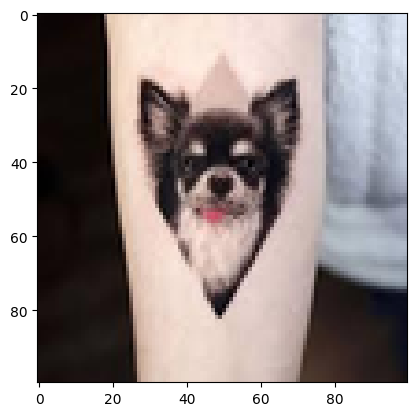

In [ ]:
#Get total number of images in the training set
num_images = train_set_x.shape[0]

#Generate a random index within the range of available images.
random_index = random.randint(0, num_images - 1)

#Displays the image and the information corresponding to the random index
plt.imshow(train_set_x[random_index])
print("y =", train_set_y[:, random_index], ", it's a '", classes[np.squeeze(train_set_y[:, random_index])], "' picture.")

### 1.3 Image flattening and normalizing functions
The function is responsible for transforming the image data by flattening and normalizing it so that it is in a more manageable format and with a consistent scale for training it in the machine learning model.

In [ ]:
def flatten_normalize_images(train_set_x, test_set_x):

    # Flatten the images: Rearrange the pixel color data of each image into a 1-dimensional array
    train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], -1).T
    test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], -1).T

    # Normalize the data by dividing the pixel values to be in the range between 0 and 1.
    train_set_x = train_set_x_flatten / 255.
    test_set_x = test_set_x_flatten / 255.

    # Return the flattened and normalized arrays of the training and test sets.
    return (train_set_x, test_set_x)

### 1.4 Train images shuffling

The function takes the flattened train set, shuffles it and returns it. This is necesary beacuse the images are not in random order, and this may have a negative effect on the model.

In [ ]:
def shuffle_train_images(train_set_x,train_set_y):

    #Merges the images with the labelss
    train_set = np.concatenate((train_set_x,train_set_y),axis=0).T #Shuffle works on the first axis

    #Shuffles the images
    np.random.seed(5) #For consistent results
    np.random.shuffle(train_set)

    #Split the images and the labels, reshape to original shape
    train_set_x = train_set[:,:-1].T
    train_set_y = train_set[:,-1:].T

    return train_set_x,train_set_y

### 1.5 Spliting the training dataset into train and validation

Function that splits the training set into training and validation

In [ ]:
def split_train_val(train_set_x_orig,train_set_y_orig,train_ratio=0.75):

    split_index = round(train_ratio*train_set_x_orig.shape[1])

    #Elements with index less or equal than 75%
    train_set_x = train_set_x_orig[:,0:split_index]
    train_set_y = train_set_y_orig[:,0:split_index]

    #Elements with index more than 75%
    val_set_x = train_set_x_orig[:,split_index:]
    val_set_y = train_set_y_orig[:,split_index:]

    return train_set_x,train_set_y,val_set_x,val_set_y

### 1.6 Function that combines image reduction with flattening and normalization for final data preparation

This function centralizes the preparation of the data sets required for training and testing the machine learning model.

In [ ]:
def prepare_train_val_test_sets(w, h):

    print('===== Loading images and reducing for desired size: ',w,'x',h,' pixels =====')

    # loading the training sets, test and classes.
    train_set_x, train_set_y, test_set_x, test_set_y, classes = load_dataset(w, h)

    print('train_set_x shape: ', train_set_x.shape)
    print('train_set_y shape: ', train_set_y.shape)
    print('test_set_x_shape: ', test_set_x.shape)
    print('test_set_y shape: ', test_set_y.shape)

    print('===== Flattenning and normalizing images =====')

    # Flattening and normalizing the images in the training and test sets.
    train_set_x, test_set_x = flatten_normalize_images(train_set_x, test_set_x)

    print('flattened and normalized train_set_x shape: ', train_set_x.shape)
    print('flattened and normalized test_set_x_shape: ', test_set_x.shape)

    print('===== Shuffling train images =====')

    train_set_x,train_set_y = shuffle_train_images(train_set_x,train_set_y)

    print('===== Splitting train set into train and validation sets =====')

    train_set_x,train_set_y,val_set_x,val_set_y = split_train_val(train_set_x,train_set_y,train_ratio=0.75)

    print('train_set_x shape: ', train_set_x.shape)
    print('train_set_y shape: ', train_set_y.shape)
    print('val_set_x shape: ', val_set_x.shape)
    print('val_set_y shape: ', val_set_y.shape)
    print('test_set_x_shape: ', test_set_x.shape)
    print('test_set_y shape: ', test_set_y.shape)

    # Returning the prepared data sets and classes.
    return train_set_x, train_set_y, val_set_x, val_set_y, test_set_x, test_set_y, classes

## 2. One layer NN model using Logistic regression

### 2.1 Model building functions

#### 2.1.1 Activation function: sigmoid

The sigmoid function takes a value 'z' and returns the result of applying the sigmoid function, which is defined as $(\sigma = \frac{1}{{1 + e^{-z}}})$, where 'e' is the base of the natural logarithm (approximately 2.71828). It is used because it return values between 0 and 1, perfect for binary classification

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#### 2.1.2 Parameter initializing

In this code, the function initialize_with_zeros takes as input the dimension representing the number of features in a model. It then initializes the model parameters (weights and bias) with initial values of zero.



In [ ]:
def initialize_with_zeros(dim):
    # initialize w as a vector of zeros.
    w = np.zeros(shape=(dim, 1))

    # Initialize b as zero
    b = 0

    # Return initialized parameters
    return w, b

#### 2.1.3 Forward and backwards propagation.

This code defines a propagate function for forward and backward propagation in a logistic regression model. Forward propagation makes predictions based on the given parameters (A=Y_pred) and calculates the cost (loss), then backwards propagation calculates the cost function gradient with the given parameters and adjust the parameters taking also into account the learning rate.

##### Arguments:
- w -- weights, a numpy array of size (num_px * num_px * 3, 1).
- b -- bias, a scalar
- X -- data of size (num_px * num_px * 3, number of examples)
- Y -- vector "label" true (contains 0 if not chihuahua, 1 if chihuahua) of size (1, number of examples).

##### Returns:
- cost -- negative log negative log-likelihood for logistic regression.
- dw -- gradient of loss with respect to w, hence same form as w
- db -- gradient of loss with respect to b, hence same shape as b

In [ ]:
def propagate(w, b, X, Y):
    # number of samples
    m = X.shape[1]

    # Forward propagation
    # Calculate the activation (Y_pred)
    A = sigmoid(np.dot(w.T, X) + b)

    # Calculate cost
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))

    # Backward propagation
    # Gradient of the loss with respect to the weights
    dw = (1 / m) * np.dot(X, (A - Y).T)

    # Gradient of loss with respect to skew
    db = (1 / m) * np.sum(A - Y)

    # Removes one-dimensional entries from the array
    cost = np.squeeze(cost)

    # Gradient dictionary
    grads = {"dw": dw,
             "db": db}

    # Return computed gradients and associated cost
    return grads, cost

#### 2.1.4 Parameters updating

The following function updates the weight and bias parameters taking into account the cost function gradient and the learning rate


##### Arguments:
- grads -- gradients, a dictionary containing the gradients for the weights (dw) and bias (db)
- w -- weights, a numpy array of size (num_px * num_px * 3, 1).
- b -- bias, a scalar
- lr -- learning rate, a scalar telling how much the parameters should be adjusted


##### Returns:
- w -- updated weights, a numpy array of size (num_px * num_px * 3, 1).
- b -- updated bias, a scalar

In [ ]:
def update_parameters(grads,w,b,lr):
    # Get the individual gradients
    dw = grads["dw"]
    db = grads["db"]

    # Update the parameters using gradient descent
    w = w - lr * dw
    b = b - lr * db
    return w,b

#### 2.1.5 Optimizer function

This code defines a function called optimize that implements the optimization process using gradient descent.

#### Arguments:
- w -- weights, a numpy array of size (num_px * num_px * 3, 1).
- b -- bias, a scalar
- X -- shape data (num_px * num_px * 3, number of examples)
- Y -- true "label" vector (contains 0 if not cat, 1 if cat), shape (1, number of examples)
- num_iterations -- number of iterations of the optimization loop
- learning_rate -- learning rate of gradient descent update rule
- print_cost -- True to print loss every 100 steps.

#### Returns:
- params -- dictionary containing weights w and bias b
- grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
- costs -- list of all costs calculated during optimization, which will be used to plot the learning curve.

In [ ]:
def optimize(w, b, X, Y,X_val,Y_val, num_iterations, learning_rate):
    iterations = []
    costs = []
    train_accuracies = []
    val_accuracies = []

    for i in range(num_iterations):

        # Calculate grads and cost.
        grads,cost = propagate(w, b, X, Y)

        #Updates parameters
        w,b = update_parameters(grads,w,b,learning_rate)

        # Record costs and accuracy
        if (i+1) % 25 == 0:
            iterations.append(i+1)
            costs.append(cost)
            # Print cost every 25 iterations
            print ("Cost after iteration %i: %f" % (i+1, cost))

            # Make predictions in the training examples.
            Y_pred_train = predict(w, b, X)
            Y_pred_val = predict(w,b,X_val)

            # Calculate the training and test accuracy
            train_accuracy = 100 - np.mean(np.abs(Y_pred_train - Y)) * 100
            val_accuracy = 100 - np.mean(np.abs(Y_pred_val - Y_val)) * 100

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)


    # Prepare the results in dictionaries
    params = {"w": w,
              "b": b}

    grads = {"dw": grads['dw'],
             "db": grads['db']}

    # Return the final results of the optimization
    return params, grads, costs, iterations, train_accuracies, val_accuracies

#### 2.1.6 Prediction function

This code fragment defines a function called predict that makes predictions using a logistic regression model.

#### Arguments:
- w -- weights, a numpy array of size (num_px * num_px * 3, 1).
- b -- bias, a scalar
- X -- data of size (num_px * num_px * 3, number of examples).

#### Returns:
- Y_prediction -- a numpy matrix (vector) containing all predictions (0/1) for the examples in X.

In [ ]:
def predict(w, b, X):
    # number of entries (examples).
    m = X.shape[1]

    # Initializes a vector of predictions
    Y_pred = np.zeros((1, m))

    # Adjust the shape of w, removing unnecessary dimensions.
    w = w.reshape(X.shape[0], 1)

    # Calculate the activations by applying the sigmoid function
    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(m):
        # Apply threshold to convert activations to binary predictions.
        Y_pred[0, i] = 1 if A[0, i] > 0.5 else 0

    # Returns the vector of predictions
    return Y_pred

#### 2.1.7 Model generation
 This code fragment defines a function called model that implements a logistic regression model for binary classification.

##### Arguments:
- X_train -- training set represented by a numpy array of form (num_px * num_px * 3, m_train).
- Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
- X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
- Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
- num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
- learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
- print_cost -- Set to true to print the cost every 100 iterations.

##### Returns:
- d -- dictionary containing information about the model.

In [ ]:
def model(X_train, Y_train, X_val, Y_val, num_iterations=200, learning_rate=0.001):

    print("====== Training model lr =",learning_rate," num_iterations =", num_iterations," ======")

    # initialize parameters with zeros.
    w, b = initialize_with_zeros(X_train.shape[0])

    # Perform gradient descent to optimize parameters.
    parameters, grads, costs, iterations, train_accuracies, val_accuracies = optimize(w, b, X_train, Y_train, X_val, Y_val, num_iterations, learning_rate)

    # Retrieves the parameters w and b from the "parameters" dictionary
    w = parameters["w"]
    b = parameters["b"]

    # Make predictions in the training and testing examples.
    Y_pred_train = predict(w, b, X_train)
    Y_pred_val = predict(w, b, X_val)

    # Calculate the training and test accuracy
    train_accuracy = 100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100
    val_accuracy = 100 - np.mean(np.abs(Y_pred_val - Y_val)) * 100

    # Print accuracy rates
    print("train accuracy: {} %".format(train_accuracy))
    print("validation accuracy: {} %".format(val_accuracy))

    # Create a dictionary with the relevant results and parameters
    d = {
         "iterations": iterations,
         "costs": costs,
         "Y_prediction_val": Y_pred_val,
         "Y_prediction_train" : Y_pred_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations" : num_iterations,
         "train_accuracy" : train_accuracy,
         "val_accuracy": val_accuracy,
         "train_accuracies" : train_accuracies,
         "val_accuracies":val_accuracies
    }

    # returns a dictionary with results and model parameters.
    return d

### 2.2 Model training and evaluation


#### 2.2.1 Picking an image size

Different image sizes ranging from 10x10 to 100x100 were picked to determine which one resulted in a better performing model using the training data and the costs and accuracy generated by the model. We concluded that a higher image size increased the accuracy on the training data. For that reason an image size of 100x100 was picked. For this experiment we used 2000 iterations and a learning rate of 0.0007 picked by manually testing learning rates.

##### 2.2.1.1 Collecting accuracy and final cost for each image size
This code automates the process of training and evaluating a machine learning model with different image sizes, and then compiles and presents the results in a tabular format for easier analysis.


In [ ]:
# Define the column names for the DataFrame
columns = ["w", "h", "train_acc","val_acc","final_cost"]

# Create an empty DataFrame with the specified columns.
image_size_vs_train_val_accuracy_df = pd.DataFrame(columns=columns)

# Iterate through the configurations and make predictions
for width, height in zip(range(10, 101, 10), range(10, 101, 10)):
    # Prepare training and test sets for the given width and height.
    train_set_x, train_set_y, val_set_x, val_set_y, test_set_x, test_set_y, classes = prepare_train_val_test_sets(width,height)

    # Perform training and evaluation of the model
    result = model(train_set_x, train_set_y, val_set_x, val_set_y, num_iterations = 2000, learning_rate = 0.0007)

    # create a dictionary representing the results for the current configuration
    point = pd.DataFrame({"w":width,
             "h":height,
             "train_acc":result["train_accuracy"],
             "val_acc":result["val_accuracy"],
             "final_cost":result["costs"][-1]},index=[0])

    # Add the results to the DataFrame
    image_size_vs_train_val_accuracy_df = pd.concat([image_size_vs_train_val_accuracy_df,point],ignore_index=True)

# print or process the DataFrame containing the results
print(image_size_vs_train_val_accuracy_df)

train_set_y shape:  (1, 4402)
test_set_x_shape:  (1183, 10, 10, 3)
test_set_y shape:  (1, 1183)
===== Flattenning and normalizing images =====
flattened and normalized train_set_x shape:  (300, 4402)
flattened and normalized test_set_x_shape:  (300, 1183)
===== Shuffling train images =====
===== Splitting train set into train and validation sets =====
train_set_x shape:  (300, 3302)
train_set_y shape:  (1, 3302)
val_set_x shape:  (300, 1100)
val_set_y shape:  (1, 1100)
test_set_x_shape:  (300, 1183)
test_set_y shape:  (1, 1183)
====== Training model lr = 0.0007  num_iterations = 2000  ======
Cost after iteration 25: 0.683778
Cost after iteration 50: 0.679945
Cost after iteration 75: 0.678283
Cost after iteration 100: 0.677396
Cost after iteration 125: 0.676790
Cost after iteration 150: 0.676286
Cost after iteration 175: 0.675822
Cost after iteration 200: 0.675373
Cost after iteration 225: 0.674932
Cost after iteration 250: 0.674496
Cost after iteration 275: 0.674062
Cost after iteratio

##### 2.2.1.2 Plotting the collected data

Plots a train accuracy and final_cost vs image width.

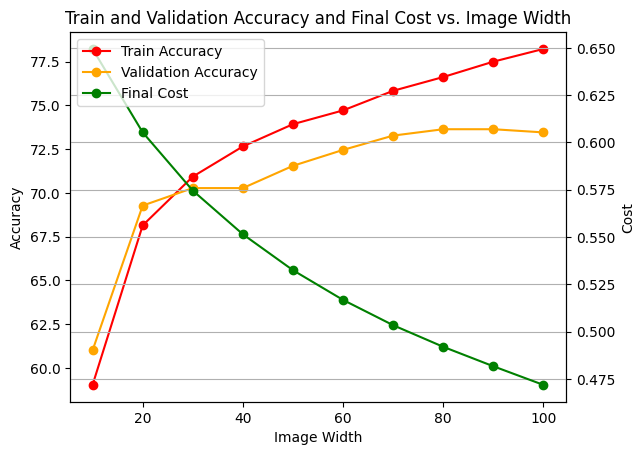

In [ ]:
# Assign the DataFrame 'image_size_vs_train_train_test_accuracy_df' to a variable 'df'.
df = image_size_vs_train_val_accuracy_df

#Creates figure and axes
fig, ax1 = plt.subplots()

#Plots train accuracy and val accuracy
ax1.plot(df["w"],df["train_acc"],marker='o', color = 'red', label='Train Accuracy')
ax1.plot(df["w"],df["val_acc"],marker='o', color = 'orange', label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Image Width')

#Plots cost
ax2 = ax1.twinx()
ax2.plot(df["w"],df["final_cost"],marker='o', color = 'green', label='Final Cost')
ax2.set_ylabel('Cost')

# Add legends for both
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Add a title to the plot
plt.title("Train and Validation Accuracy and Final Cost vs. Image Width")

# Enable a grid on the plot
plt.grid(True)

# Show the plot
plt.show()

#### 2.2.2 Picking a learning rate

##### 2.2.2.1 Collecting the costs data and accuracy data per learning rate

This code performs an analysis of different learning rates in a training model, collecting and storing the costs and the resulting iterations for each rate. This allows to evaluate how different learning rates affect the performance (accuracy) and training process of the model. For this experiment the number of iterations was fixed to 2000 and image size to 80x80 pixels as it showed the higher validation accuracy.

We found the best learning rate to be ?????? the highest to show no signs of 'jumping' during model optimization.

In [ ]:
# Load training and test sets together with the corresponding classes.
# Image size was set to 100x100
train_set_x, train_set_y,val_set_x, val_set_y, test_set_x, test_set_y, classes = prepare_train_val_test_sets(80,80)

===== Loading images and reducing for desired size:  80 x 80  pixels =====
train_set_x shape:  (4402, 80, 80, 3)
train_set_y shape:  (1, 4402)
test_set_x_shape:  (1183, 80, 80, 3)
test_set_y shape:  (1, 1183)
===== Flattenning and normalizing images =====
flattened and normalized train_set_x shape:  (19200, 4402)
flattened and normalized test_set_x_shape:  (19200, 1183)
===== Shuffling train images =====
===== Splitting train set into train and validation sets =====
train_set_x shape:  (19200, 3302)
train_set_y shape:  (1, 3302)
val_set_x shape:  (19200, 1100)
val_set_y shape:  (1, 1100)
test_set_x_shape:  (19200, 1183)
test_set_y shape:  (1, 1183)


In [ ]:
# List of learning rates to test
learning_rates = [0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014]

# Create lists to store the data
costs_costs_dict = {}
iter_iter_dict = {}
accuracy_train_list = []
accuracy_val_list = []

# Iterate over learning rates and record data.
for lr in learning_rates:
    print("Training model with learning rate: ",lr)
    result = model(train_set_x, train_set_y, val_set_x, val_set_y, num_iterations = 2000, learning_rate = lr)

    # Add the data to the lists
    costs_costs_dict[lr] = (result["costs"])
    iter_iter_dict[lr] = (result['iterations'])
    accuracy_train_list.append(result['train_accuracy'])
    accuracy_val_list.append(result['val_accuracy'])

Training model with learning rate:  0.0004
====== Training model lr = 0.0004  num_iterations = 2000  ======
Cost after iteration 25: 0.663866
Cost after iteration 50: 0.651101
Cost after iteration 75: 0.640589
Cost after iteration 100: 0.631794
Cost after iteration 125: 0.624324
Cost after iteration 150: 0.617890
Cost after iteration 175: 0.612276
Cost after iteration 200: 0.607318
Cost after iteration 225: 0.602894
Cost after iteration 250: 0.598907
Cost after iteration 275: 0.595284
Cost after iteration 300: 0.591964
Cost after iteration 325: 0.588902
Cost after iteration 350: 0.586060
Cost after iteration 375: 0.583407
Cost after iteration 400: 0.580919
Cost after iteration 425: 0.578575
Cost after iteration 450: 0.576357
Cost after iteration 475: 0.574253
Cost after iteration 500: 0.572249
Cost after iteration 525: 0.570335
Cost after iteration 550: 0.568503
Cost after iteration 575: 0.566745
Cost after iteration 600: 0.565055
Cost after iteration 625: 0.563427
Cost after iteration

##### 2.2.2.2 Plotting cost vs iteration for different learning rates

This code contributes to the creation of the graph by plotting a line showing how costs change over iterations for a the evaluated learning rates.


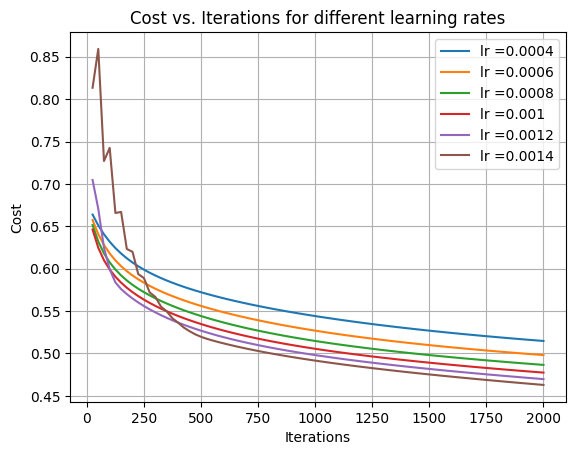

In [ ]:
# Iterate through different learning rates
for i in learning_rates:
    # Plot the data corresponding to this learning rate.
    plt.plot( iter_iter_dict[i], costs_costs_dict[i], label=("lr =" + str(i)) )

# Add labels to the x- and y-axis of the plot
plt.xlabel("Iterations")
plt.ylabel("Cost")

# Add a title to the graph
plt.title("Cost vs. Iterations for different learning rates")

# Display a legend to indicate which line represents which data set
plt.legend()

#plt.xscale('log')

# Enable a grid on the graph
plt.grid(True)

# Show the graph
plt.show()

##### 2.2.2.3 Plotting train accuracy vs learning rates

This code contributes to the creation of the graph by plotting a line showing how train accuracy changes for the evaluated learning rates.

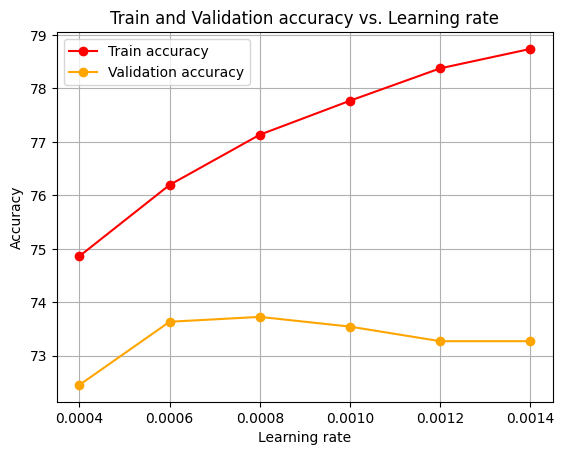

In [ ]:
plt.plot(learning_rates, accuracy_train_list,color='r',marker = 'o',label=('Train accuracy'))
plt.plot(learning_rates, accuracy_val_list,color='orange',marker = 'o',label=('Validation accuracy'))

# Add labels to the x- and y-axis of the plot
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")

# Add a title to the graph
plt.title("Train and Validation accuracy vs. Learning rate")

# Display a legend to indicate which line represents which data set
plt.legend()

#plt.xscale('log')

# Enable a grid on the graph
plt.grid(True)

# Show the graph
plt.show()

#### 2.2.3 Optimizing the number of iterations

##### 2.2.3.1 Preparing the images with size 80x80

In [ ]:
# Load training and test sets together with the corresponding classes.
train_set_x, train_set_y,val_set_x, val_set_y, test_set_x, test_set_y, classes = prepare_train_val_test_sets(80,80)

===== Loading images and reducing for desired size:  80 x 80  pixels =====
train_set_x shape:  (4402, 80, 80, 3)
train_set_y shape:  (1, 4402)
test_set_x_shape:  (1183, 80, 80, 3)
test_set_y shape:  (1, 1183)
===== Flattenning and normalizing images =====
flattened and normalized train_set_x shape:  (19200, 4402)
flattened and normalized test_set_x_shape:  (19200, 1183)
===== Shuffling train images =====
===== Splitting train set into train and validation sets =====
train_set_x shape:  (19200, 3302)
train_set_y shape:  (1, 3302)
val_set_x shape:  (19200, 1100)
val_set_y shape:  (1, 1100)
test_set_x_shape:  (19200, 1183)
test_set_y shape:  (1, 1183)


##### 2.2.3.2 Obtaining costs and accuracies data

The functions trains the model with 5000 iterations. Accuracies are saved for every 25 iterations and returned with the model, is received for plotting purposes.

In [ ]:
num_iter_list = []
train_accuracies = []
val_accuracies = []
costs = []

# Call to the model function to train and evaluate a model with training and test data, using specific parameters.
result = model(train_set_x, train_set_y, val_set_x, val_set_y, num_iterations = 10000, learning_rate = 0.0008)

#Extract relevant data from the model for optimization of number of iterations
train_accuracies = result['train_accuracies']
costs = result['costs']
num_iter_list = result['iterations']
val_accuracies = result['val_accuracies']

====== Training model lr = 0.0008  num_iterations = 10000  ======
Cost after iteration 25: 0.651519
Cost after iteration 50: 0.632063
Cost after iteration 75: 0.618078
Cost after iteration 100: 0.607460
Cost after iteration 125: 0.599019
Cost after iteration 150: 0.592057
Cost after iteration 175: 0.586140
Cost after iteration 200: 0.580989
Cost after iteration 225: 0.576421
Cost after iteration 250: 0.572307
Cost after iteration 275: 0.568556
Cost after iteration 300: 0.565104
Cost after iteration 325: 0.561902
Cost after iteration 350: 0.558912
Cost after iteration 375: 0.556106
Cost after iteration 400: 0.553462
Cost after iteration 425: 0.550960
Cost after iteration 450: 0.548586
Cost after iteration 475: 0.546328
Cost after iteration 500: 0.544175
Cost after iteration 525: 0.542119
Cost after iteration 550: 0.540152
Cost after iteration 575: 0.538267
Cost after iteration 600: 0.536458
Cost after iteration 625: 0.534720
Cost after iteration 650: 0.533049
Cost after iteration 675: 0

##### 2.2.3.3 Plotting cost and accuracy as a function of iterations

This code generates a graph showing how the cost and accuracy varies as a function of iterations.

In [ ]:
iters_stack = np.array(num_iter_list).reshape((-1,1))
train_acc_stack = np.array(train_accuracies).reshape((-1,1))
val_acc_stack = np.array(val_accuracies).reshape(-1,1)
stacked = np.hstack((iters_stack,train_acc_stack,val_acc_stack))

print(stacked)

[[   25.            58.54027862    60.81818182]
 [   50.            64.05208964    66.27272727]
 [   75.            66.35372502    67.54545455]
 ...
 [ 9950.            83.10115082    75.18181818]
 [ 9975.            83.10115082    75.18181818]
 [10000.            83.16172017    75.18181818]]


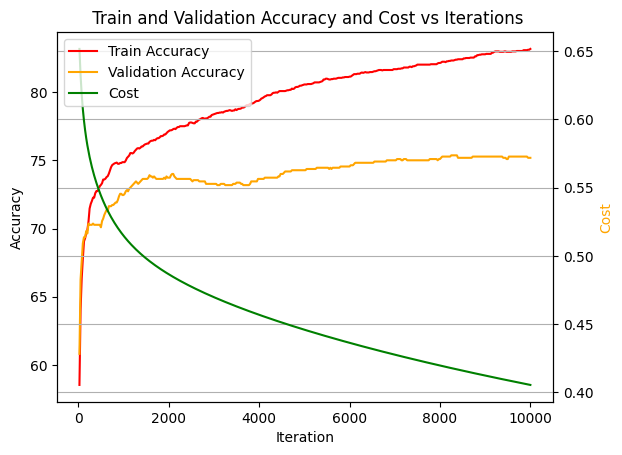

In [ ]:
#Creates figure and axes
fig, ax1 = plt.subplots()

#Plots train accuracy
ax1.plot(num_iter_list,train_accuracies, color = 'red', label='Train Accuracy')
ax1.plot(num_iter_list,val_accuracies, color = 'orange', label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Iteration')

#Plots cost
ax2 = ax1.twinx()
ax2.plot(num_iter_list,costs, color = 'green', label='Cost')
ax2.set_ylabel('Cost',color='orange')

# Add legends for both
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Add a title to the plot
plt.title(" Train and Validation Accuracy and Cost vs Iterations")

# Enable a grid on the plot
plt.grid(True)

# Show the plot
plt.show()

#### 2.2.4 Training the model with the optimized parameters

Using a learning rate of 0.0008, 2100 iterations and an image size of 80x80

#### 2.2.4.1 Preparing the images with size 80x80

In [ ]:
# Load training and test sets together with the corresponding classes.
train_set_x, train_set_y, val_set_x, val_set_y, test_set_x, test_set_y, classes = prepare_train_val_test_sets(80,80)

train_set_x = np.concatenate((train_set_x,val_set_x),axis=1)
train_set_y = np.concatenate((train_set_y,val_set_y),axis=1)

===== Loading images and reducing for desired size:  80 x 80  pixels =====
train_set_x shape:  (4402, 80, 80, 3)
train_set_y shape:  (1, 4402)
test_set_x_shape:  (1183, 80, 80, 3)
test_set_y shape:  (1, 1183)
===== Flattenning and normalizing images =====
flattened and normalized train_set_x shape:  (19200, 4402)
flattened and normalized test_set_x_shape:  (19200, 1183)
===== Shuffling train images =====
===== Splitting train set into train and validation sets =====
train_set_x shape:  (19200, 3302)
train_set_y shape:  (1, 3302)
val_set_x shape:  (19200, 1100)
val_set_y shape:  (1, 1100)
test_set_x_shape:  (19200, 1183)
test_set_y shape:  (1, 1183)


#### 2.2.4.2 Training and evaluating the model

This line of code makes a call to the model function, which is in charge of training and evaluating a model.

In [ ]:
# Call to the model function to train and evaluate a model with training and test data, using specific parameters.
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2100, learning_rate = 0.0008)

print("=========================================================")
print("Training accuracy: {} %".format(d["train_accuracy"]))
print("Test accuracy: {} %".format(d["val_accuracy"]))

====== Training model lr = 0.0008  num_iterations = 2100  ======
Cost after iteration 25: 0.650229
Cost after iteration 50: 0.631346
Cost after iteration 75: 0.617918
Cost after iteration 100: 0.607812
Cost after iteration 125: 0.599836
Cost after iteration 150: 0.593293
Cost after iteration 175: 0.587755
Cost after iteration 200: 0.582952
Cost after iteration 225: 0.578704
Cost after iteration 250: 0.574887
Cost after iteration 275: 0.571414
Cost after iteration 300: 0.568223
Cost after iteration 325: 0.565267
Cost after iteration 350: 0.562511
Cost after iteration 375: 0.559928
Cost after iteration 400: 0.557495
Cost after iteration 425: 0.555196
Cost after iteration 450: 0.553017
Cost after iteration 475: 0.550946
Cost after iteration 500: 0.548973
Cost after iteration 525: 0.547089
Cost after iteration 550: 0.545288
Cost after iteration 575: 0.543563
Cost after iteration 600: 0.541909
Cost after iteration 625: 0.540321
Cost after iteration 650: 0.538794
Cost after iteration 675: 0.

## 3. NN model with 1 hidden layer

The neural network with the hidden layer has two weight matrices (one weight vector per hidden layer neuron) and two bias vectors, one of each one per layer. Each neuron in the hidden layer takes the image features and calculates z, pass it through an activation function (tanh) that feeds the next layer with new parameters,those new parameters are processed using another weight vector; finally another activation function (sigmoid) converts that input into a prediction (chihuahua or muffin). The loss (cost) is calculated based on the final prediction, that takes into account both vectors.

In [ ]:
# Load training and test sets together with the corresponding classes.
# Image size was set to 80x80
train_set_x, train_set_y, val_set_x, val_set_y, test_set_x, test_set_y, classes = prepare_train_val_test_sets(80,80)

===== Loading images and reducing for desired size:  80 x 80  pixels =====
train_set_x shape:  (4402, 80, 80, 3)
train_set_y shape:  (1, 4402)
test_set_x_shape:  (1183, 80, 80, 3)
test_set_y shape:  (1, 1183)
===== Flattenning and normalizing images =====
flattened and normalized train_set_x shape:  (19200, 4402)
flattened and normalized test_set_x_shape:  (19200, 1183)
===== Shuffling train images =====
===== Splitting train set into train and validation sets =====
train_set_x shape:  (19200, 3302)
train_set_y shape:  (1, 3302)
val_set_x shape:  (19200, 1100)
val_set_y shape:  (1, 1100)
test_set_x_shape:  (19200, 1183)
test_set_y shape:  (1, 1183)


### 3.1 Model functions





#### 3.1.1 Defining the layer sizes

This function takes the image dataset, the desired hidden layer size and the labels vector and returns a tuple containing the number of images in X (size_x), the number of labels to predict in Y (size_y) and the hidden layers size (size_h). The hidden layer size is not optimized during this work, so its fixed to an arbitrary value of 200

### Inputs:

- X --- dataframe, flatten and normalized images
- size_h --- integer, hidden layer size
- Y --- series (vector), labels

##### Returns:
- size_x --- integer, the number of images
- size_h --- integer, the hidden layer size
- size_y --- integer, the number of outputs


In [ ]:
def layer_sizes(X, size_h, Y):
    # Input layer size (features size)
    size_x = X.shape[0]

    # Hidden layer size
    size_h = size_h

    # Output layer size (response)
    size_y = Y.shape[0]

    # Returning a tuple containing the calculated sizes
    return (size_x, size_h, size_y)

In this code snippet, a function called layer_sizes is being used to determine the sizes of the different layers of a neural network. The sizes are printed individually for the input, hidden, and output layers.


In [ ]:
# Get the sizes of the layers using the function layer_sizes
(size_x,size_h,size_y) = layer_sizes(train_set_x,200,train_set_y)

print("The size of the input layer is: size_x = ",size_x)
print("The size of the hidden layer is: size_h = ",size_h)
print("The size of the output layer is: size_y = ",size_y)

The size of the input layer is: size_x =  19200
The size of the hidden layer is: size_h =  200
The size of the output layer is: size_y =  1


#### 3.1.2 Initializing parameters

In this code, we are defining a function called initialize_parameters that initializes the parameters of the neural network based on the calculated and defined layer_sizes

##### Inputs
- size_x --- integer, the number of images
- size_h --- integer, the hidden layer size
- size_y --- integer, the number of outputs

##### Returns:

- W1 --- Weight matrix of size size_h*size_x (each hidden layer neuron has each own weight vector corresponding to th features of the images)
- b1 --- bias vector of size size_h (one bias value per neuron in the hidden layer)
- W2 --- Weight matrix of size size_y*size_h (one weight vector per output neuron, the weight vector with size of the hidden layer)
- b2 --- bias vector (one per neuron on the output layer)


In [ ]:
def initialize_parameters(size_x,size_h,size_y):
    # Set a seed to generate reproducible random numbers
    np.random.seed(2)

    #Weight matrix of size size_h*size_x (each neuron has each own weight vector)
    W1 = np.random.randn(size_h, size_x)*0.01

    #bias vector of size size_h (one b per neuron in hidden layer)
    b1 = np.zeros((size_h,1))

    #Weight matrix of size size_y*size_h (one weight vector per output neuron, the weight vector with size of the hidden layer)
    W2 = np.random.randn(size_y,size_h)*0.01

    #bias vector (one b per output layer neuron)
    b2 = np.zeros((size_y,1))

    # Storing the parameters in a dictionary
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    # Return the initialized parameters
    return parameters

In this code, the parameters of a neural network are being initialized and then the shapes (dimensions) of the weight matrices and bias vectors corresponding to the layers of the neural network are being printed.


In [ ]:
# Initialize the parameters of the neural network
parameters = initialize_parameters(size_x,size_h,size_y)

# Print the shapes of the matrices and vectors
print("W1 shape: ", parameters["W1"].shape)
print("b1 shape: ", parameters["b1"].shape)
print("W2 shape: ", parameters["W2"].shape)
print("b2 shape: ", parameters["b2"].shape)

W1 shape:  (200, 19200)
b1 shape:  (200, 1)
W2 shape:  (1, 200)
b2 shape:  (1, 1)


#### 3.1.3 Forward propagation

Calculates the raw prediction (A2) based on the current weights vectors. It also saves the intermediate value Z1, A1 and Z2

##### Inputs:
- X --- dataframe, the flattened and normalized images
- parameters ---  dictionary, contains the weights matrices and bias vectors saved ad W1, b1, W2 and b2

##### Returns
- A2 --- array, the raw predictions for the images with the given parameters
- cache --- dictionary, stores the intermediate values Z1, A1 and Z2, also A2 required for backwards propagation


In [ ]:
def forward_propagation(X, parameters):
    # Unpack the parameters
    #Wx = weight
    #bx= bias
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Forward propagation at layer 1
    Z1 = np.dot(W1, X) + b1 # Dot product of W1 and the X inputs plus the bias b1
    A1 = np.tanh(Z1) # Hyperbolic tangent activation function applied to Z1

    # Forward propagation at layer 2
    Z2 = np.dot(W2, A1) + b2 # Dot product of W2 and activations A1 plus bias b2
    A2 = sigmoid(Z2) # Application of the sigmoid function to Z2 to obtain A2

    # Create a cache dictionary to store the intermediate values
    cache = {"Z1":Z1,
             "A1":A1,
             "Z2":Z2,
             "A2":A2}

    # Return the final activations of layer 2 and the cache dictionary
    return A2, cache

#### 3.1.4 Cost function and backwards propagation

The calculate_cost function is defined to calculate the cost (cross-entropy) of the predictions compared to the true labels.

##### Inputs:
- A2 --- series, vector of predicted labels (raw, there are on decimal format)
- Y ---  series, vector of labels

##### Returns
- cost --- cross-entropy cost


In [ ]:
#Calculates the cost function (cross-entropy) based on:
# predictions based on current model parameters (A2), true labels (Y)

def calculate_cost(A2, Y):
    # Number of training examples
    m = Y.shape[1]

    # Calculate the cost using the cross-entropy formula
    cost = (-1/m)*np.sum(np.multiply(Y,np.log(A2))+np.multiply((1-Y), np.log(1-A2)))

    # Makes sure cost is a scalar
    cost = float(np.squeeze(cost))

    # Returns the value of the calculated cost
    return cost

This code snippet represents a backpropagation function in a neural network, it calculates the corresponding gradients

##### Inputs:
- parameters ---  dictionary, contains the weights matrices and bias vectors saved ad W1, b1, W2 and b2
- cache --- dictionary, stores the intermediate values Z1, A1 and Z2, also A2 required for backwards propagation
- X --- dataframe, flattened and normalized images
- Y --- series, labels

##### Returns
- grads --- dictionary containing the gradients as dW1, db1, dW2 and db2


In [ ]:
def backward_propagation(parameters, cache, X, Y):
    # Get the number of training examples
    m= X.shape[1]

    # Extract parameters and model cache
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    A1 = cache["A1"] # Layer 1 activations
    A2 = cache["A2"] # Layer 2 activations
    Z1 = cache["Z1"] # Linear results from layer 1
    Z2 = cache["Z2"] # Layer 2 linear results

    # Calculate gradients for layer 2
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T) # Gradient for W2 weights
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True) # Gradient for bias b2

    # Calculate gradients for layer 1
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T) # Gradient for W1 weights
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True) # Gradient for bias b1

    # Store gradients in a dictionary
    grads = {"dW1":dW1,
             "db1":db1,
             "dW2":dW2,
             "db2":db2}

    # Return the calculated gradients
    return grads

#### 3.1.5 Function for parameters updating

This code snippet defines a function called update_parameters that is used to update the parameters of a neural network using the gradient descent method.

#### Arguments:
- parameters --- dictionary, A dictionary containing the current network parameters.
- grads --- dictionary, A dictionary containing the gradients computed for each parameter.
- learning_rate -- float: Learning rate to control the size of the update steps.

#### Returns:
- parameters --- dictionary, a new dictionary containing the updated parameters after gradient descent.


In [ ]:
def update_parameters_2(parameters, grads, learning_rate):

    # Extract the current parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Extract the gradients
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Update parameters using gradient descent
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2

    # Create a new dictionary with the updated parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    # Return the dictionary with the updated parameters after gradient descent.
    return parameters

#### 3.1.6 The model training function
The code snippet defines a function called model_two_layers that implements a two-layer neural network model to perform supervised training using the functions defined before


##### Arguments:
- X --- training images
- Y --- true labels
- learning_rate --- How much the parameters are adjusted during gradient descent
- num_iterations --- The number of optimization steps
- hidden_layer_size --- The size of the hidden layer (number of neurons)

##### Returns:
- parameters --- The model parameters (W1, W2, b1, b2) and some extra info (costs, iterations)

In [ ]:
def model_two_layers(X,Y,X_val,Y_val, learning_rate, num_iterations = 200,hidden_layer_size=100):
    # Get the dimensions of input (size_x), hidden layer (size_h) and output (size_y)
    (size_x,size_h,size_y) = layer_sizes(train_set_x,hidden_layer_size,train_set_y)

    # Initialize the parameters of the neural network
    parameters = initialize_parameters(size_x,size_h,size_y)

    costs = []
    iterations = []
    train_accuracies = []
    val_accuracies = []

    # Training cycle
    for i in range (1,num_iterations+1):
        # Perform forward propagation and get the activations from the output layer (A2)
        A2, cache = forward_propagation(X,parameters)

        # Calculate the cost using the cost function
        cost = calculate_cost(A2, Y)

        # Perform backpropagation to compute gradients
        grads = backward_propagation(parameters, cache, X, Y)

        # Update parameters using gradient descent
        parameters = update_parameters_2(parameters,grads,learning_rate)

        # Print the cost and accuracy every 10 iterations
        if i%10 == 0:
            costs.append(cost)
            iterations.append(i)

            # Predict train set examples
            Y_pred_train = predict_two_layers(parameters, X)
            Y_pred_val = predict_two_layers(parameters, X_val)

            train_accuracy = 100 - np.mean(np.abs(Y_pred_train - Y)) * 100
            val_accuracy = 100 - np.mean(np.abs(Y_pred_val - Y_val)) * 100

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            print("Cost after iteration %i: %f" %(i,cost),"====== train accuracy: {} %".format(train_accuracy),"==== val accuracy =", val_accuracy,"%")


    parameters['costs'] = costs
    parameters['iterations'] = iterations
    parameters['train_accuracies'] = train_accuracies
    parameters['val_accuracies'] = val_accuracies

    # Return the trained parameters
    return parameters

#### 3.1.7 Predictions
This code snippet defines a function called predict_two_layers that takes parameters and input data. It uses a two-layer neural network to make a binary prediction.

##### Arguments:
- parameters --- dictionary, model parameters
- X --- matrix, contains the image data for predictions

##### Returns:
- predictions --- array, predicted labels

In [ ]:
def predict_two_layers(parameters, X):
    # Perform forward propagation of the two-layer neural network.
    A2, cache = forward_propagation(X,parameters)

    # Generate predictions based on the output of the final layer (A2) using a threshold of 0.5.
    predictions = (A2 > 0.5)

    # Return the resulting predictions.
    return predictions

### 3.2 Model training and evaluation

#### Evaluate model function

The function evaluate_model performs the evaluation of a two-layer model using training and test sets, calculates the accuracy, and prints it to the output.

##### Arguments:
- parameters --- dictionary, model parameters
- X --- dataframe, the train images
- Y --- series, train labels
- X_test --- dataframe, the test images
- Y_test --- series, the test labels

##### Returns:
- train_accuracy --- float
- test_accuracy --- float

In [ ]:
def evaluate_model(parameters, X, Y, X_test, Y_test):

    # Predict test/train set examples
    Y_pred_train = predict_two_layers(parameters, X)
    Y_pred_test = predict_two_layers(parameters, X_test)

    train_accuracy = 100 - np.mean(np.abs(Y_pred_train - Y)) * 100
    test_accuracy = 100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100

    # Print train/test Errors
    print("train accuracy: {} %".format(train_accuracy))
    print("test accuracy: {} %".format(test_accuracy))

    return train_accuracy, test_accuracy

#### 3.2.1 Choosing a learning rate

#### 3.2.1.1 Evaluating different learning rates

The following code snipet creates models with different learning rates to find which performs better in terms of jumping and cost optimization.

In [ ]:
# List of learning rates to test
learning_rates_2 = [0.004, 0.006, 0.008, 0.01, 0.012]

# Create lists to store the data
costs_costs_dict_2 = {}
iter_iter_dict_2 = {}
accuracy_list_2 = []
val_accuracy_list_2=[]

# Iterate over learning rates and record data.
for lr in learning_rates_2:
    print("Training model with learning rate: ",lr)
    result = model_two_layers(train_set_x, train_set_y, val_set_x, val_set_y, learning_rate = lr, num_iterations = 500, hidden_layer_size=200)

    # Add the data to the lists
    costs_costs_dict_2[lr] = (result["costs"])
    iter_iter_dict_2[lr] = (result['iterations'])

    train_accuracy,val_accuracy = evaluate_model(result,train_set_x,train_set_y,val_set_x,val_set_y)

    accuracy_list_2.append(train_accuracy)
    val_accuracy_list_2.append(val_accuracy)

Training model with learning rate:  0.004
Cost after iteration 10: 0.678173 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 20: 0.675810 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 30: 0.673964 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 40: 0.672140 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 50: 0.670289 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 60: 0.668399 ====== train accuracy: 57.41974560872199 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 70: 0.666464 ====== train accuracy: 57.41974560872199 % ==== val accuracy = 59.909090909090914 %
Cost after iteration 80: 0.664483 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 60.0 %
Cost after iteration 90: 0.6

##### 3.2.1.2 Plotting cost vs iteration for different learning rates

This code contributes to the creation of the graph by plotting a line showing how costs change over iterations for a the evaluated learning rates.


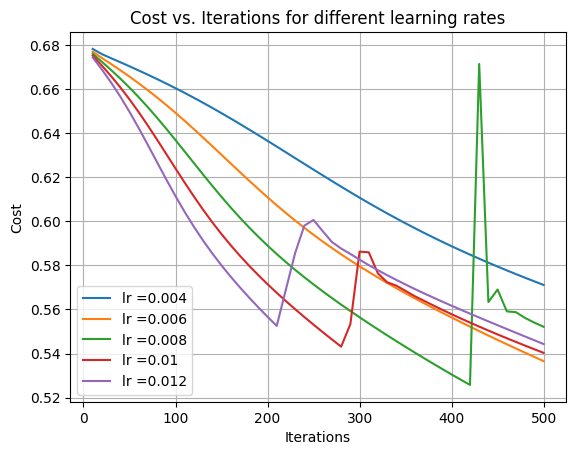

In [ ]:
# Iterate through different learning rates
for i in learning_rates_2:
    # Plot the data corresponding to this learning rate.
    plt.plot( iter_iter_dict_2[i], costs_costs_dict_2[i], label=("lr =" + str(i)) )

# Add labels to the x- and y-axis of the plot
plt.xlabel("Iterations")
plt.ylabel("Cost")

# Add a title to the graph
plt.title("Cost vs. Iterations for different learning rates")

# Display a legend to indicate which line represents which data set
plt.legend()

#plt.xscale('log')

# Enable a grid on the graph
plt.grid(True)

# Show the graph
plt.show()

#### 3.2.1.3 Plotting accuracy vs learning rates

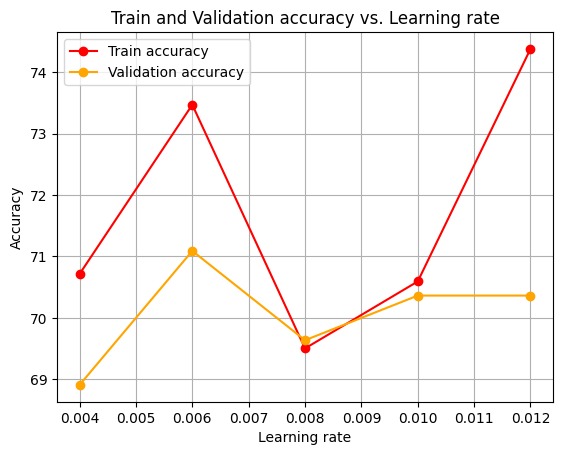

In [ ]:
plt.plot(learning_rates_2, accuracy_list_2,color='red',marker = 'o',label=('Train accuracy'))
plt.plot(learning_rates_2, val_accuracy_list_2,color='orange',marker = 'o',label=('Validation accuracy'))

# Add labels to the x- and y-axis of the plot
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")

# Add a title to the graph
plt.title("Train and Validation accuracy vs. Learning rate")

# Display a legend to indicate which line represents which data set
plt.legend()

#plt.xscale('log')

# Enable a grid on the graph
plt.grid(True)

# Show the graph
plt.show()

#### 3.2.2 Choosing the number of iterations

In [ ]:
# Call to the model function to train and evaluate a model with training and test data, using specific parameters.
result_2 = model_two_layers(train_set_x, train_set_y, val_set_x, val_set_y, num_iterations = 2000, learning_rate = 0.006, hidden_layer_size=200)

Cost after iteration 10: 0.676925 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 20: 0.674057 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 30: 0.671318 ====== train accuracy: 57.389460932768024 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 40: 0.668505 ====== train accuracy: 57.41974560872199 % ==== val accuracy = 59.72727272727273 %
Cost after iteration 50: 0.665593 ====== train accuracy: 57.41974560872199 % ==== val accuracy = 60.0 %
Cost after iteration 60: 0.662570 ====== train accuracy: 57.51059963658388 % ==== val accuracy = 59.909090909090914 %
Cost after iteration 70: 0.659421 ====== train accuracy: 57.66202301635373 % ==== val accuracy = 59.909090909090914 %
Cost after iteration 80: 0.656137 ====== train accuracy: 58.29800121138704 % ==== val accuracy = 60.54545454545455 %
Cost after iteration 90: 0.652720 ====== train accuracy: 59.297395517867

In [ ]:
#Extract relevant data from the model for optimization of number of iterations
train_accuracies_2 = result_2['train_accuracies']
val_accuracies_2 = result_2['val_accuracies']
costs_2 = result_2['costs']
num_iter_list_2 = result_2['iterations']

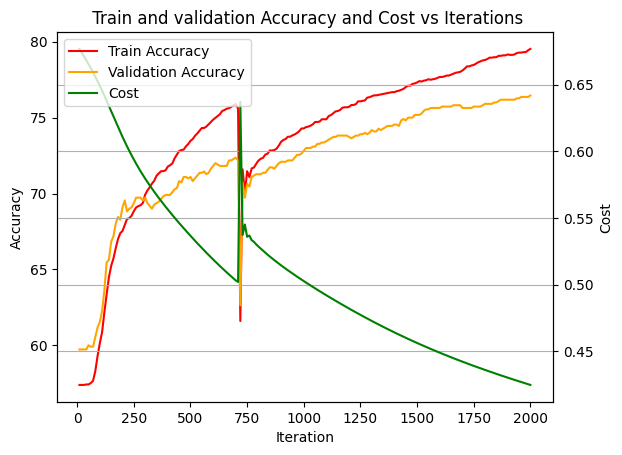

In [ ]:
#Creates figure and axes
fig, ax1 = plt.subplots()

#Plots train accuracy
ax1.plot(num_iter_list_2,train_accuracies_2, color = 'red', label='Train Accuracy')
ax1.plot(num_iter_list_2,val_accuracies_2, color = 'orange', label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Iteration')

#Plots cost
ax2 = ax1.twinx()
ax2.plot(num_iter_list_2,costs_2, color = 'green', label='Cost')
ax2.set_ylabel('Cost')

# Add legends for both
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Add a title to the plot
plt.title(" Train and validation Accuracy and Cost vs Iterations")

# Enable a grid on the plot
plt.grid(True)

# Show the plot
plt.show()

#### 3.2.3 Model evaluation with the choosen parameters

In [ ]:
#Merges train and val sets
train_set_x = np.concatenate((train_set_x,val_set_x),axis=1)
train_set_y = np.concatenate((train_set_y,val_set_y),axis=1)

# Train model with 2 layers on train val
# Printed val accuracy is actually test accuracy
parameters_final = model_two_layers(train_set_x,train_set_y, test_set_x, test_set_y, learning_rate=0.006,num_iterations=2000,hidden_layer_size=200)

Cost after iteration 10: 0.675312 ====== train accuracy: 57.97364834166288 % ==== val accuracy = 54.099746407438715 %
Cost after iteration 20: 0.672432 ====== train accuracy: 57.97364834166288 % ==== val accuracy = 54.099746407438715 %
Cost after iteration 30: 0.669710 ====== train accuracy: 57.97364834166288 % ==== val accuracy = 54.099746407438715 %
Cost after iteration 40: 0.666910 ====== train accuracy: 58.01908223534757 % ==== val accuracy = 54.099746407438715 %
Cost after iteration 50: 0.664010 ====== train accuracy: 58.04179918218991 % ==== val accuracy = 54.099746407438715 %
Cost after iteration 60: 0.661000 ====== train accuracy: 58.04179918218991 % ==== val accuracy = 54.353338968723584 %
Cost after iteration 70: 0.657874 ====== train accuracy: 58.20081781008633 % ==== val accuracy = 54.52240067624683 %
Cost after iteration 80: 0.654628 ====== train accuracy: 58.72330758746024 % ==== val accuracy = 54.94505494505494 %
Cost after iteration 90: 0.651265 ====== train accuracy: 5

In [ ]:
# Call the function 'evaluate_model' with the final parameters and the training and test sets
evaluate_model(parameters_final, train_set_x, train_set_y, test_set_x,test_set_y)

train accuracy: 81.46297137664698 %
test accuracy: 77.76838546069315 %


(81.46297137664698, 77.76838546069315)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=27d47510-abdd-41d4-a457-e8db884ab1fd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>